# 0. Install and import libraries

In [3]:
# open-cv to pre-process the data
# matplotlib used to render the results
# imageio to create gifs of frames together
# gdown used to download the dataset from google drive
# tensorflow for building a deep neural network
!pip install opencv-python matplotlib imageio gdown tensorflow

In [5]:
import os #easier to navigate through different file systems
import cv2 #opencv to pre-process and load videos
import tensorflow as tf #for deep learning
import numpy as np #arrays
from typing import List #annotations
from matplotlib import pyplot as plt #rendering of outputs
import imageio #converting numpy arrays to gifs

In [7]:
# For efficient memory usage of GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Building data loading functions

In [10]:
import gdown
# downloading data directly from google drive

In [12]:
# download and extract the dataset from google drive
# This is for one speaker from the GRID corpus
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=45c7e18f-2e05-434a-8805-5074c30e8271
To: /Users/AliHasan_1/Desktop/data.zip
100%|██████████| 423M/423M [00:40<00:00, 10.5MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [14]:
# pre-processing function to load videos
# take the data path and output a list of float that represents the video
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path) #create an instance of cv2 with data path
    frames = [] #looping through videos to capture frames
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) #less data to pre-process
        frames.append(frame[190:236,80:220,:]) #slicing the frames on the mouth region
    cap.release()
    
    mean = tf.math.reduce_mean(frames) #mean
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) #standard deviation
    return tf.cast((frames - mean), tf.float32) / std #standardization of frames

In [16]:
# defining vocabulary
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [18]:
# conversion between characters and numbers, to make it easy to feed data to our model
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") # easy conversion from characters to numbers
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
) # easy conversion from numbers to characters
# invert=true to convert from numbers to characters not the other way
# oov_token (out of vocabulary token) - token for the voacabulary which is not seen before will be blank
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [20]:
# Example character to number conversion
char_to_num(['a','l','i'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 1, 12,  9])>

In [22]:
# Example number to character conversion
num_to_char([ 1, 12,  9])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'a', b'l', b'i'], dtype=object)>

In [24]:
# function to load alignments (transcriptions)
# we will split the lines in the alignments file
# silence (sil) will be ignored
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [26]:
# loading the alignments and video frames simultaneously
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [28]:
# taking a random file as test path
test_path = './data/s1/bbal6n.mpg'
# loading the file name
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [30]:
# extracting the frames and alignments from the test path file
frames, alignments = load_data(tf.convert_to_tensor(test_path))

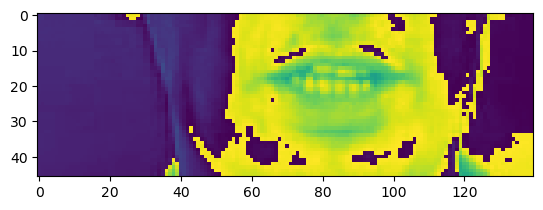

In [32]:
# plotting a frame showing the mouth region of the speaker in the test path file
plt.imshow(frames[40])
# the highlighted regions (yellow) are being isolated here

In [34]:
# printing the alignment of the test path file (transcription of what the speaker is saying)
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [36]:
# this function is helpful when creating data pipelines using tensorflow
# it will be used for string processing
# will return result in convenient float32 and int64 formats
from typing import Tuple
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
      result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
      return result

# 2. Creating data pipeline

In [39]:
# taking all of the mpg files
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# shuffles the data in batches of 500
data = data.shuffle(500, reshuffle_each_iteration=False)
# returning the data in previously specified formats in the mappable_function
data = data.map(mappable_function)
# padding into group size of 2 - each batch will have 2 videos and 2 alignments
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# prefetching - pre-loading the data as the model is still training
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split 
train = data.take(450)  # Take the first 450 samples for training
test = data.skip(450)    # Skip the first 450 samples for testing

In [41]:
# Extracting the frames and alignments from our data
frames, alignments = data.as_numpy_iterator().next()

In [43]:
# testing the numpy iterator
sample = data.as_numpy_iterator()
# "next" to capture the next instance of the pipeline
val = sample.next(); val[0] #returning values for videos

array([[[[[ 1.4157355 ],
          [ 1.4550616 ],
          [ 1.4550616 ],
          ...,
          [ 0.19662994],
          [ 0.11797796],
          [ 0.11797796]],

         [[ 1.4157355 ],
          [ 1.4550616 ],
          [ 1.4157355 ],
          ...,
          [ 0.19662994],
          [ 0.11797796],
          [ 0.11797796]],

         [[ 1.4157355 ],
          [ 1.4157355 ],
          [ 1.3764095 ],
          ...,
          [ 0.11797796],
          [ 0.07865197],
          [ 0.07865197]],

         ...,

         [[ 1.0224756 ],
          [ 1.0224756 ],
          [ 0.98314965],
          ...,
          [ 9.910149  ],
          [ 9.910149  ],
          [ 9.910149  ]],

         [[ 1.0224756 ],
          [ 1.0224756 ],
          [ 0.98314965],
          ...,
          [ 9.870823  ],
          [ 9.870823  ],
          [ 9.870823  ]],

         [[ 1.0224756 ],
          [ 1.0224756 ],
          [ 0.98314965],
          ...,
          [ 9.870823  ],
          [ 9.870823  ],
          

In [45]:
# Creating a gif
# eventually our model will be trained on these gifs of frames
# Convert the frames to uint8  
# val[0][0] is the frame we want to save  
frames_to_save = (val[0][0] * 255).astype(np.uint8)  
# If frames_to_save has an extra dimension, we may need to squeeze it  
# For example, if the shape is (75, 190, 140, 1), we can remove the last dimension  
if frames_to_save.ndim == 4:  # Check if there's an extra dimension  
    frames_to_save = np.squeeze(frames_to_save)  
# Save the frames as a GIF  
imageio.mimsave('./animation.gif', frames_to_save, fps=10) 

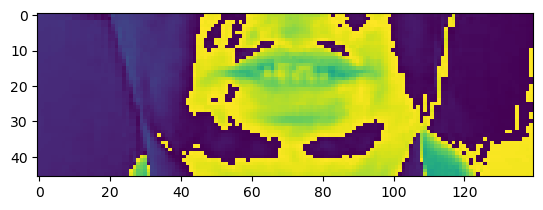

In [47]:
# Plotting the frame image
# [0]:videos, [0]: 1st video out of the batch,  [35]: return the 35th frame in the video 
plt.imshow(val[0][0][35])

In [49]:
# printing the sentence of the alignment (val[1][0])
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s eight sp please'>

# 3. Designing the deep neural network

In [52]:
# importing important deep learning libraries
# conv3d for video processing
# LSTM for recurrent neural network
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
# modelcheckpoint will save the model at the end of every epoch
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [54]:
data.as_numpy_iterator().next()[0][0].shape # we are using this shape of our data as input_shape in the next cell

(75, 46, 140, 1)

In [56]:
model = Sequential()
# 128 3d convolutional kernels, 3x3x3 in size, input_shape as aforementioned,
# padding = same to preserve the shape of our inputs
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu')) # for non-linearity
model.add(MaxPool3D((1,2,2))) # will take max values inside each frame and condense it to 2x2 square

# same as above with some different values
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# same as above with some different values
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
# allows us to have 75 inputs into LSTM in order to output text characters
model.add(TimeDistributed(Flatten()))

In [60]:
# 128 lstm kernels, return all 75 units not just 1 (return_sequences = true)
# bidirectional to pass the state from both left to right and vice versa for better model performance
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5)) #regularization (.5 - 50% of units dropped)

#another lstm layer
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

In [62]:
# dense layer will produce one hot encoded representations of characters
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [64]:
# Printing the model summary
model.summary()
# observe that the time distributed layer has flattened the output of the immediate above max pooling layer
# 6375 = 5 x 17 x 75

# the bidirectional layers have 256 units because 2 (bi) x 128

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Training the model

In [67]:
# defining a learning rate scheduler
# for more than 30 epochs, we are modifying the learning rate using an exponential function
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [69]:
# defining the ctc loss function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [71]:
# outputting the original alignment and the prediction made by the model
# callbacks used to call this function on every epoch
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset # .as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        # ctc_decode will help in generating the final predictions from one hot encoded ones
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [73]:
# compiling the model
# specifying the optimizer, learning rate, and loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)  

In [77]:
# callbacks
# this will save our model's checkpoints
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 
# allows us to modify the learning rate each epoch
schedule_callback = LearningRateScheduler(scheduler)
# will make predictions after each epoch to see how the model is training
example_callback = ProduceExample(data)
# fitting the model to the data, specifying the callbacks, and the epochs
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


2024-11-03 12:36:35.949686: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-11-03 12:36:35.949706: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-11-03 12:36:35.949716: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-11-03 12:36:35.949722: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-11-03 12:36:35.949727: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-11-03 12:36:35.949729: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed a

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/time_distributed_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/opt/anaconda3/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/opt/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/3q/__s0447x3gqc0tzm_50zz52m0000gn/T/ipykernel_28732/732163145.py", line 9, in <module>

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 584, in call

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/time_distributed.py", line 108, in call

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/time_distributed.py", line 102, in step_function

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 4728, in reshape

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 1851, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/time_distributed_1/Reshape}}]] [Op:__inference_one_step_on_iterator_29011]